In [77]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from aif360.sklearn.metrics import *
import pandas as pd
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from sklearn.linear_model import LogisticRegression
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

In [78]:
data_dir = "data"
def add_train_use(data_dir, df=None):
    if df is None:
        df = pd.read_csv(f"{data_dir}/metadata.csv")
    train_files = [f for f in os.listdir(f"{data_dir}/train/malade/") if f[-4:]=='.png']
    train_files.extend(
        [f for f in os.listdir(f"{data_dir}/train/sain/") if f[-4:]=='.png']
    )
    valid_files = [f for f in os.listdir(f"{data_dir}/valid/malade/") if f[-4:]==".png"]
    valid_files.extend(
        [f for f in os.listdir(f"{data_dir}/valid/sain/") if f[-4:]==".png"]
    )
    df["train"] = df["Image Index"].apply(lambda x: x in train_files)
    return df

In [79]:
dataset = add_train_use(data_dir, df=None)
dataset

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],WEIGHTS,train
0,00000018_000.png,No Finding,0,18,75,M,PA,2500,2048,0.168000,0.168000,1,True
1,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168000,0.168000,1,True
2,00000056_001.png,Effusion,1,56,76,M,PA,2992,2991,0.143000,0.143000,1,True
3,00000104_000.png,Pleural_Thickening,0,104,68,F,PA,2906,2991,0.143000,0.143000,1,True
4,00000104_001.png,No Finding,1,104,69,F,PA,2734,2991,0.143000,0.143000,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,No Finding,0,30749,22,F,PA,2021,2021,0.194311,0.194311,1,True
5239,00030754_000.png,Infiltration,0,30754,54,M,PA,2020,2021,0.194314,0.194314,1,True
5240,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311,1,True
5241,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311,1,True


## Analyse des données et préprocessing

In [80]:
# NaN
print("Nombre de NaN : ", dataset.isna().sum())
dataset.rename(columns={'OriginalImage[Width': 'OriginalImage_width', 'Height]': 'OriginalImage_height', 'OriginalImagePixelSpacing[x': 'OriginalImagePixelSpacing_x', 'y]' : 'OriginalImagePixelSpacing_y'}, inplace=True)

Nombre de NaN :  Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
WEIGHTS                        0
train                          0
dtype: int64


Nous pouvons remarquer que notre dataframe ne contient pas de NaN, toutes les entrées sont complètes.

In [81]:
# On supprime les anomalies (comme un sexe différent pour la même ID de Patient) (On a au préalable vérifier que le nombre d'entrées concernées était minime)
# (comme cela leur suppression n'affectera pas nos données)
patient_counts = dataset.groupby('Patient ID')['Patient Gender'].nunique()

patients_to_remove = patient_counts[patient_counts > 1].index
print("On supprime : ", patients_to_remove.shape[0], " patients")

df_filtered = dataset[ ~dataset['Patient ID'].isin(patients_to_remove)]

On supprime :  0  patients


In [82]:
# on ne garde que les patients ayant un âge raisonable
# on peut se permettre de supprimer entièrement les entrées puisque le nombre d'entrées affectées est très faible comparé au nombre total d'entrées
print("On supprime : ", df_filtered[(df_filtered['Patient Age'] < 0)].shape[0] + df_filtered[(df_filtered['Patient Age'] > 120)].shape[0], " patients"   )
df_filtered = df_filtered[(df_filtered['Patient Age'] >= 0) & (df_filtered['Patient Age'] <= 120)]

On supprime :  0  patients


In [83]:
df_filtered = df_filtered.reset_index(drop=True)
df_filtered

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,WEIGHTS,train
0,00000018_000.png,No Finding,0,18,75,M,PA,2500,2048,0.168000,0.168000,1,True
1,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168000,0.168000,1,True
2,00000056_001.png,Effusion,1,56,76,M,PA,2992,2991,0.143000,0.143000,1,True
3,00000104_000.png,Pleural_Thickening,0,104,68,F,PA,2906,2991,0.143000,0.143000,1,True
4,00000104_001.png,No Finding,1,104,69,F,PA,2734,2991,0.143000,0.143000,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,No Finding,0,30749,22,F,PA,2021,2021,0.194311,0.194311,1,True
5239,00030754_000.png,Infiltration,0,30754,54,M,PA,2020,2021,0.194314,0.194314,1,True
5240,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,0.194311,1,True
5241,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,0.194311,1,True


In [84]:
data_bool = df_filtered['OriginalImagePixelSpacing_x'] != df_filtered['OriginalImagePixelSpacing_y']
sum = data_bool.sum()
assert sum == 0 # toutes les valeurs des deux colonnes sont donc identiques (images carrées ?)
# on décide d'en supprimer une
df_filtered = df_filtered.drop('OriginalImagePixelSpacing_y', axis='columns')

In [85]:
print("Before preprocessing : ", dataset.shape)
print("After preprocessing : ", df_filtered.shape)
taille = df_filtered.shape[0]

Before preprocessing :  (5243, 13)
After preprocessing :  (5243, 12)


In [86]:
assert len(df_filtered['Image Index'].unique()) == taille # verification qu'il n'y a pas de répétitions de la même image

In [87]:
# On transforme les labels: 'No Finding' = 0, autre chose = 1
df_filtered["Disease"] = df_filtered["Finding Labels"].apply(lambda x: 0.0 if x == "No Finding" else 1.0)


In [88]:
df_filtered

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease
0,00000018_000.png,No Finding,0,18,75,M,PA,2500,2048,0.168000,1,True,0.0
1,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168000,1,True,1.0
2,00000056_001.png,Effusion,1,56,76,M,PA,2992,2991,0.143000,1,True,1.0
3,00000104_000.png,Pleural_Thickening,0,104,68,F,PA,2906,2991,0.143000,1,True,1.0
4,00000104_001.png,No Finding,1,104,69,F,PA,2734,2991,0.143000,1,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,No Finding,0,30749,22,F,PA,2021,2021,0.194311,1,True,0.0
5239,00030754_000.png,Infiltration,0,30754,54,M,PA,2020,2021,0.194314,1,True,1.0
5240,00030792_000.png,No Finding,0,30792,10,F,PA,1775,1712,0.194311,1,True,0.0
5241,00030792_001.png,No Finding,1,30792,10,F,PA,1663,1675,0.194311,1,True,0.0


In [89]:
df_filtered.drop(columns='Finding Labels', inplace=True)
df_filtered

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease
0,00000018_000.png,0,18,75,M,PA,2500,2048,0.168000,1,True,0.0
1,00000056_000.png,0,56,76,M,PA,2500,2048,0.168000,1,True,1.0
2,00000056_001.png,1,56,76,M,PA,2992,2991,0.143000,1,True,1.0
3,00000104_000.png,0,104,68,F,PA,2906,2991,0.143000,1,True,1.0
4,00000104_001.png,1,104,69,F,PA,2734,2991,0.143000,1,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,0,30749,22,F,PA,2021,2021,0.194311,1,True,0.0
5239,00030754_000.png,0,30754,54,M,PA,2020,2021,0.194314,1,True,1.0
5240,00030792_000.png,0,30792,10,F,PA,1775,1712,0.194311,1,True,0.0
5241,00030792_001.png,1,30792,10,F,PA,1663,1675,0.194311,1,True,0.0


In [90]:
df_filtered['Follow-up #'].unique()  # verification que le nombre de Follow-up est "normal"

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108])

### Univariate analysis of the numerical columns


#### Sexe

In [91]:
df_filtered['Patient Gender'].describe() # Les hommes sont représentés par des 0, les femmes par des 1

count     5243
unique       2
top          M
freq      2734
Name: Patient Gender, dtype: object

In [92]:
print("Femmes : ", str(round(df_filtered["Patient Gender"].value_counts()[1]/taille * 100, 2)) + "%" )
print("Hommes : ", str(round(df_filtered["Patient Gender"].value_counts()[0]/taille * 100, 2)) + "%" )

Femmes :  47.85%
Hommes :  52.15%


/tmp/ipykernel_5598/2335643381.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Femmes : ", str(round(df_filtered["Patient Gender"].value_counts()[1]/taille * 100, 2)) + "%" )
/tmp/ipykernel_5598/2335643381.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Hommes : ", str(round(df_filtered["Patient Gender"].value_counts()[0]/taille * 100, 2)) + "%" )


Il y a une représentation plutôt égalitaire entre les hommes et les femmes dans nos données (même si il a plus d'hommes)

#### Age

In [93]:
df_filtered['Patient Age'].describe()

count    5243.000000
mean       48.126836
std        16.438970
min         2.000000
25%        37.000000
50%        50.000000
75%        60.000000
max        92.000000
Name: Patient Age, dtype: float64

Nous pouvons remarquer que l'âge le plus élevé est maintenant de 92 ans, le plus bas est de 2 ans.


La moyenne d'âge est d'environ 48 ans, avec un écart type d'environ 16 ans.


Une forte concentration de patient entre 37 et 60 ans semble être présente.

#### Maladie

In [94]:
print("Nombre de personnes malades : ", df_filtered[ df_filtered['Disease'] == 1 ].shape[0], f"soit {(df_filtered[ df_filtered['Disease'] == 1 ].shape[0])/taille *100:.2f}% de nos patients"  )
print("Nombre de personnes non malades : ", df_filtered[ df_filtered['Disease'] == 0 ].shape[0], f"soit {(df_filtered[ df_filtered['Disease'] == 0 ].shape[0])/taille *100:.2f}% de nos patients"  )

Nombre de personnes malades :  2429 soit 46.33% de nos patients
Nombre de personnes non malades :  2814 soit 53.67% de nos patients


La proportion de personnes malades dans la population semble plutôt égalitaire.

#### Global

In [95]:
# On définit les features numériques
numerical_features =    set(list(df_filtered.select_dtypes(include=np.number).columns)) - (set(['Disease', 'WEIGHTS']))
print(numerical_features)
# /!\ Pour le moment on choisit de considérer Follow up et Patient Age comme des données numériques,
# on pourrait les regrouper par tranches et les considérer comme des données catégorielles (ce qu'on fera plus tard)

{'Follow-up #', 'OriginalImage_width', 'Patient ID', 'Patient Age', 'OriginalImage_height', 'OriginalImagePixelSpacing_x'}


In [96]:
df_filtered['WEIGHTS']=1.0

In [97]:
df_filtered

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease
0,00000018_000.png,0,18,75,M,PA,2500,2048,0.168000,1.0,True,0.0
1,00000056_000.png,0,56,76,M,PA,2500,2048,0.168000,1.0,True,1.0
2,00000056_001.png,1,56,76,M,PA,2992,2991,0.143000,1.0,True,1.0
3,00000104_000.png,0,104,68,F,PA,2906,2991,0.143000,1.0,True,1.0
4,00000104_001.png,1,104,69,F,PA,2734,2991,0.143000,1.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,0,30749,22,F,PA,2021,2021,0.194311,1.0,True,0.0
5239,00030754_000.png,0,30754,54,M,PA,2020,2021,0.194314,1.0,True,1.0
5240,00030792_000.png,0,30792,10,F,PA,1775,1712,0.194311,1.0,True,0.0
5241,00030792_001.png,1,30792,10,F,PA,1663,1675,0.194311,1.0,True,0.0


In [98]:
# Fonction qui retourne la correlation entre deux colonnes d'une dataframe
def Compute_correlation(dataframe, cola, colb):
  return np.corrcoef(dataframe[cola].values, dataframe[colb].values)[0][1]

In [99]:
# Compute les correlations des attributs numériques avec le label
label="Disease"
for num_feature in numerical_features:
  print(num_feature, Compute_correlation(df_filtered,label, num_feature))

Follow-up # 0.18658101527990964
OriginalImage_width 0.05906130806500683
Patient ID 0.07180664855248048
Patient Age 0.09647427108869358
OriginalImage_height -0.01720747729785093
OriginalImagePixelSpacing_x -0.030800849114685523


On remarque que pour chaque maladie et pour une maladie en générale, les corrélations avec ces features numériques sont très faibles.

La corrélation la plus élévée est avec la feature Follow-up avec une corrélation de 0.17 ce qui est faible et ne montre pas de corrélation.

### Bivariate analysis

In [100]:
categorical_features = ["View Position", "Patient Gender"] # pour le moment on choisit ces features catégorielles à étudiées
print(categorical_features)

['View Position', 'Patient Gender']


In [152]:
import matplotlib.pyplot as plt
def Display_categorical_hist_percent2(feature, label): # plot le pourcentage de probabilité d'un label selon les valeurs d'une feature
    percentage_df = df_filtered.groupby([feature, label]).size().reset_index(name='count')
    total_counts = df_filtered.groupby(feature).size().reset_index(name='total')
    percentage_df = percentage_df.merge(total_counts, on=feature)
    percentage_df['percentage'] = (percentage_df['count'] / percentage_df['total']) * 100
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature, y='percentage', hue=label, data=percentage_df)
    plt.title(f'Distribution des pourcentages de {feature} pour {label}')
    plt.ylabel('Pourcentage')
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.legend(title=label)
    plt.show()

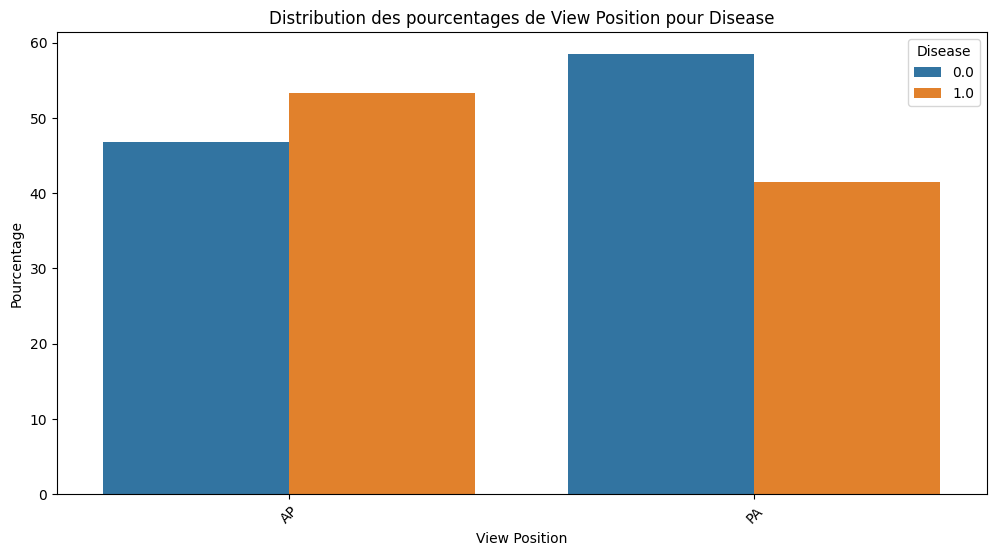

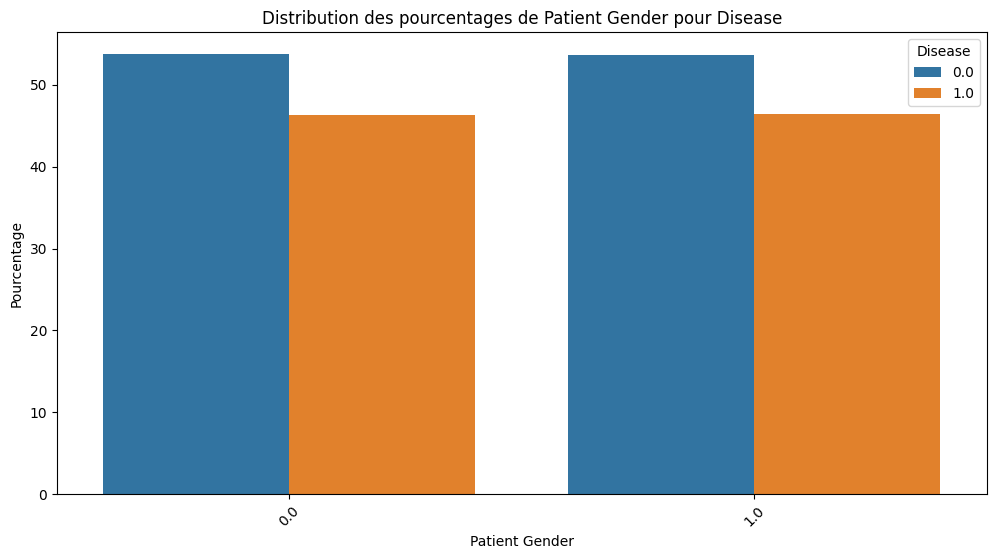

In [153]:
for cat_feature in categorical_features:
  Display_categorical_hist_percent2(cat_feature, 'Disease')

On peut remarquer un possible biais entre View Position et Maladie. En effet la probabilité d'être malade est plus importnate que celle de ne pas l'être lorsque la View Position est "AP", alors que c'est l'inverse sinon. Ce biais potentiel ne semble pas exister entre View Position et Infiltration.

La feature Patient Gender ne semble pas créer de biais avec Maladie ou Infiltration (même probabilité dominante avec environ 2% seulement de différence)

### Table de contigence

In [103]:
for x in df_filtered.columns :
    print(pd.crosstab(df_filtered[x], df_filtered["Disease"])) # on utilise crosstab de pandas

Disease           0.0  1.0
Image Index               
00000018_000.png    1    0
00000056_000.png    0    1
00000056_001.png    0    1
00000104_000.png    0    1
00000104_001.png    1    0
...               ...  ...
00030749_000.png    1    0
00030754_000.png    0    1
00030792_000.png    1    0
00030792_001.png    1    0
00030793_000.png    0    1

[5243 rows x 2 columns]
Disease       0.0  1.0
Follow-up #           
0            1025  475
1             411  260
2             251  204
3             177  159
4             128  137
...           ...  ...
104             0    1
105             0    1
106             0    1
107             1    0
108             1    0

[109 rows x 2 columns]
Disease     0.0  1.0
Patient ID          
18            1    0
56            0    2
104           1    1
160           1    0
171           1    0
...         ...  ...
30734         1    0
30749         1    0
30754         0    1
30792         2    0
30793         0    1

[1500 rows x 2 columns]
Dis

In [104]:
# on ajoute une colonne pour l'âge en décennie (plus facile à examiner)
bins_age = list(range(0, 121, 10))  # Tranches de 10 ans (0-10, 11-20, ..., 111-120)
age = [f"{b}-{b+9}" for b in bins_age[:-1]] 

# Ajout d'une nouvelle colonne avec les groupes d'âges
df_filtered['Age Group'] = pd.cut(df_filtered['Patient Age'], bins=bins_age, labels=age, right=False)


bins_followup = list(range(0, 183, 5))  
folup = [f"{b}-{b+4}" for b in bins_followup[:-1]]
df_filtered['Follow-up Group'] = pd.cut(df_filtered['Follow-up #'], bins=bins_followup, labels=folup, right=False)

In [105]:
df_filtered

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease,Age Group,Follow-up Group
0,00000018_000.png,0,18,75,M,PA,2500,2048,0.168000,1.0,True,0.0,70-79,0-4
1,00000056_000.png,0,56,76,M,PA,2500,2048,0.168000,1.0,True,1.0,70-79,0-4
2,00000056_001.png,1,56,76,M,PA,2992,2991,0.143000,1.0,True,1.0,70-79,0-4
3,00000104_000.png,0,104,68,F,PA,2906,2991,0.143000,1.0,True,1.0,60-69,0-4
4,00000104_001.png,1,104,69,F,PA,2734,2991,0.143000,1.0,True,0.0,60-69,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,0,30749,22,F,PA,2021,2021,0.194311,1.0,True,0.0,20-29,0-4
5239,00030754_000.png,0,30754,54,M,PA,2020,2021,0.194314,1.0,True,1.0,50-59,0-4
5240,00030792_000.png,0,30792,10,F,PA,1775,1712,0.194311,1.0,True,0.0,10-19,0-4
5241,00030792_001.png,1,30792,10,F,PA,1663,1675,0.194311,1.0,True,0.0,10-19,0-4


/tmp/ipykernel_5598/4230884425.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df_filtered.groupby([feature, label]).size().reset_index(name='count')
/tmp/ipykernel_5598/4230884425.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_filtered.groupby(feature).size().reset_index(name='total')


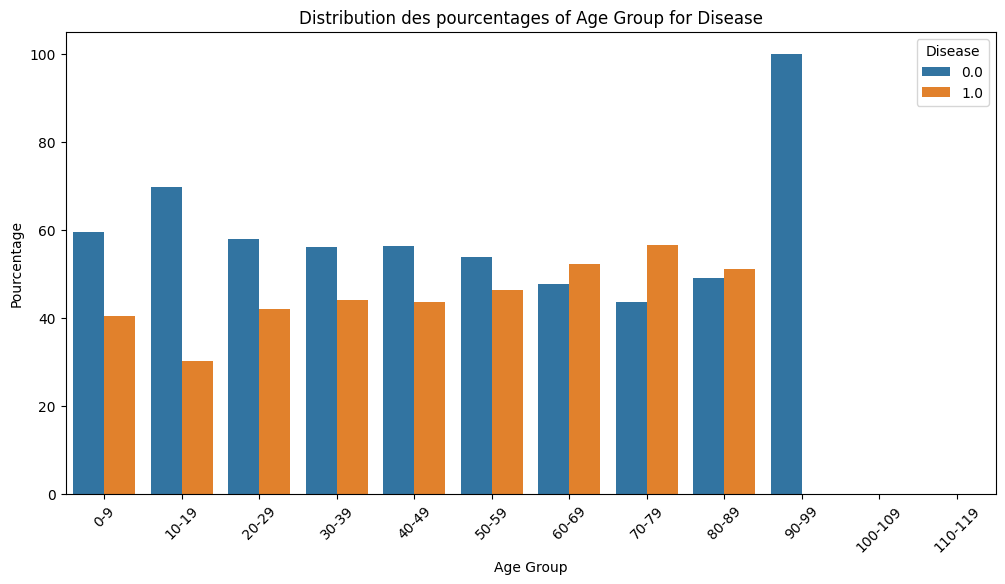

In [106]:
Display_categorical_hist_percent2('Age Group', 'Disease')

/tmp/ipykernel_5598/4230884425.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df_filtered.groupby([feature, label]).size().reset_index(name='count')
/tmp/ipykernel_5598/4230884425.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df_filtered.groupby(feature).size().reset_index(name='total')


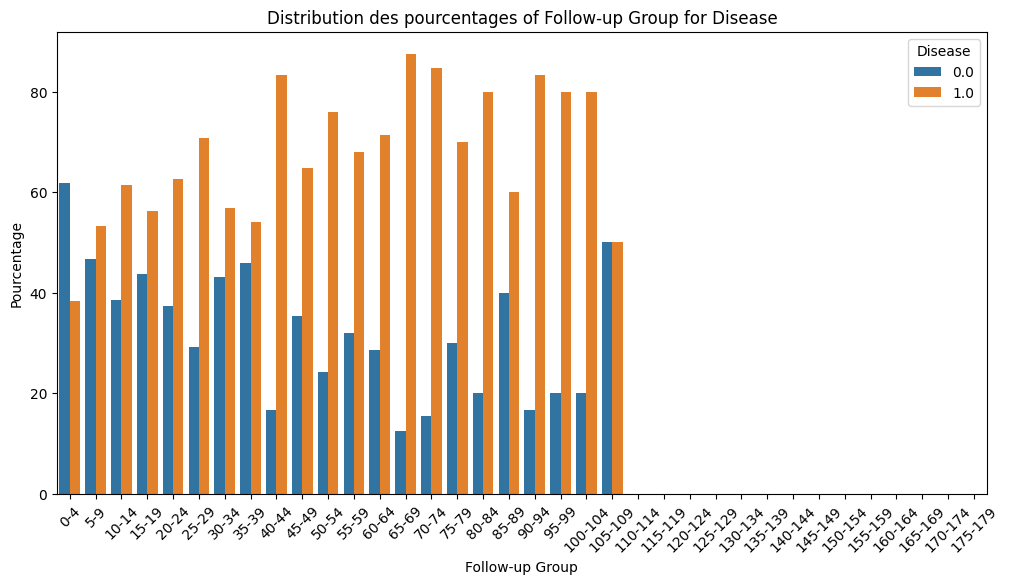

In [107]:
Display_categorical_hist_percent2('Follow-up Group', 'Disease')

On remarque un biais sur l'âge. En effet de 0 à 60 ans le patient a une probabilité plus haute de ne pas avoir de maladie. De 60 à 90 ans un patient a une probabilité plus haute d'être malade. ( Néanmoins de 90 à 100 ans la probabilité de ne pas avoir de maladie est beaucoup plus forte que celle d'en avoir une, cela est probablement dû au nombre très faible de données sur cette tranche d'âge. )

In [108]:
print("Nombre de patient de plus de 90 ans : ", df_filtered[ df_filtered['Patient Age'] >= 90].shape[0])

Nombre de patient de plus de 90 ans :  1


On remarque un autre biais sur le graphique des Follow-up. Entre 0 et 4 Follow-up la probabilité de ne pas être malade est de plus de 60%. (Ce qui semble être logique). De 5 Follow-up à 99 Follow-up la probabilité d'être malade est plus forte. Néanmoins de 100 à 105 Follow-up la probabilité de ne pas être malade ets d'environ 50%. Ce qui ne semble pas forcement logique.

Comme précedemment cela est probablement lié au manque de données avec un aussi grand nombre de Follow-up.

In [109]:
print("Nombre de patient avec plus de 175 Follow-up : ", df_filtered[ df_filtered['Follow-up #'] >= 100].shape[0])

Nombre de patient avec plus de 175 Follow-up :  9


On décide de créer deux nouveaux attributs : 

- Age Sensible (correspond à une colonne binaire qui indique si le patient a plus de 60 ans ou non)(On a choisit le seuil de 60 ans car c'est à cet âge que l'on a remarqué un changement dans la probabilité de maladie)

- Follow-up Sensible (correspond à une colonne binaire qui indique si le patient a plus de 5 follow-up ou non)(On a choisit le seuil de 5 follow-up car c'est à ce nombre que l'on a remarqué un changement dans la probabilité de maladie)

In [110]:
df_filtered['Age Sensible'] = (df_filtered['Patient Age'] >= 60)
df_filtered['Follow-up Sensible'] = (df_filtered['Follow-up #'] >= 5)
df_filtered

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease,Age Group,Follow-up Group,Age Sensible,Follow-up Sensible
0,00000018_000.png,0,18,75,M,PA,2500,2048,0.168000,1.0,True,0.0,70-79,0-4,True,False
1,00000056_000.png,0,56,76,M,PA,2500,2048,0.168000,1.0,True,1.0,70-79,0-4,True,False
2,00000056_001.png,1,56,76,M,PA,2992,2991,0.143000,1.0,True,1.0,70-79,0-4,True,False
3,00000104_000.png,0,104,68,F,PA,2906,2991,0.143000,1.0,True,1.0,60-69,0-4,True,False
4,00000104_001.png,1,104,69,F,PA,2734,2991,0.143000,1.0,True,0.0,60-69,0-4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,0,30749,22,F,PA,2021,2021,0.194311,1.0,True,0.0,20-29,0-4,False,False
5239,00030754_000.png,0,30754,54,M,PA,2020,2021,0.194314,1.0,True,1.0,50-59,0-4,False,False
5240,00030792_000.png,0,30792,10,F,PA,1775,1712,0.194311,1.0,True,0.0,10-19,0-4,False,False
5241,00030792_001.png,1,30792,10,F,PA,1663,1675,0.194311,1.0,True,0.0,10-19,0-4,False,False


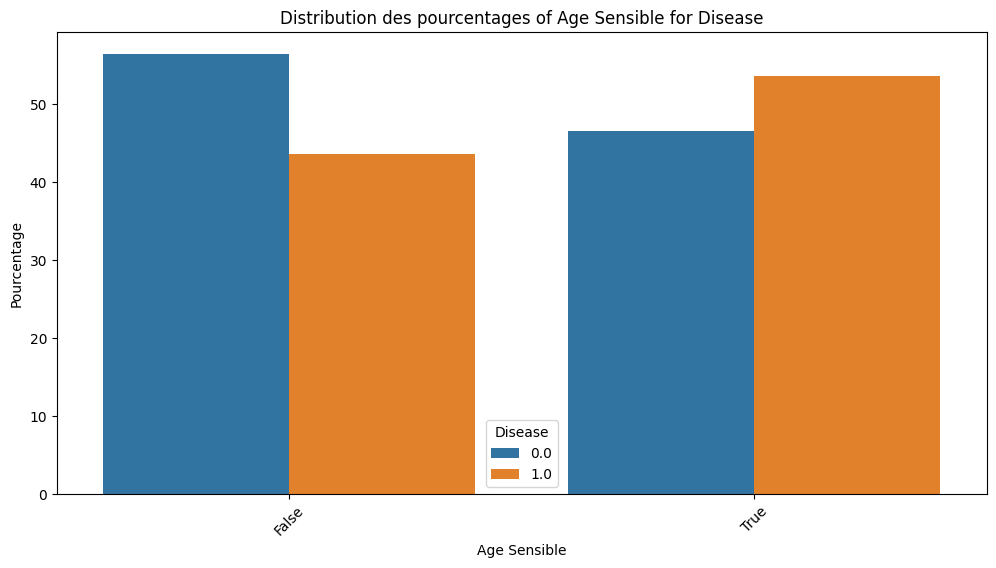

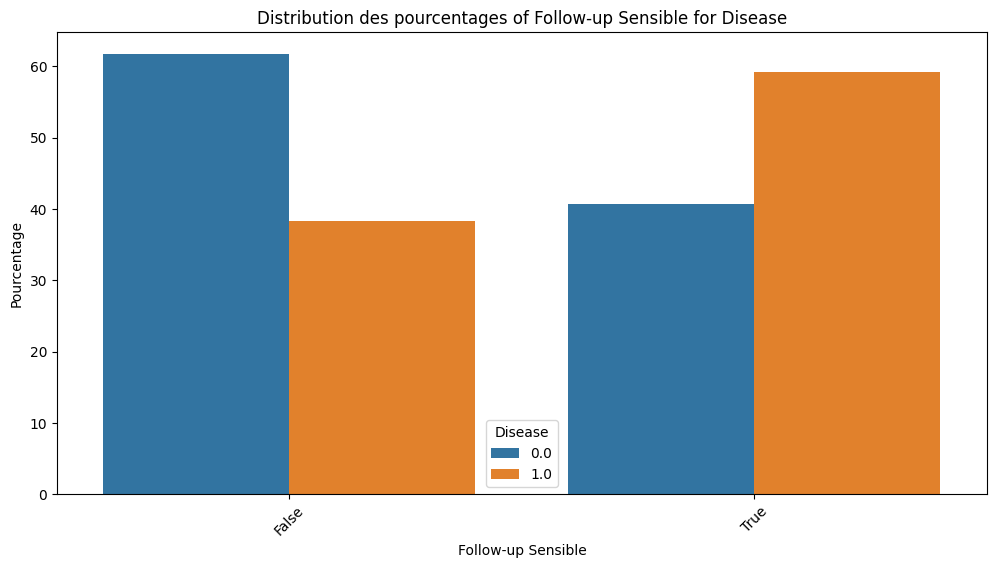

In [111]:
Display_categorical_hist_percent2('Age Sensible', 'Disease')
Display_categorical_hist_percent2('Follow-up Sensible', 'Disease')

On change la colonne du sexe du patient en une colonne binaire et on supprime la colonne Image Index pour nous faciliter l'étude

In [112]:
df_filtered["Patient Gender"] = df_filtered["Patient Gender"].apply(lambda x: 0.0 if x == "M" else 1.0)
image_index = df_filtered['Image Index']
df_filtered.drop('Image Index', inplace=True, axis=1)

On supprime également les colonnes Age Group et Follow-up Group comme leurs informations principales sont stockées dans Age Sensible et Follow-up Sensible

In [113]:
df_filtered.drop('Age Group', inplace=True, axis=1)
df_filtered.drop('Follow-up Group', inplace=True, axis=1)

## REWEIGHTING

In [114]:
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from aif360.sklearn.metrics import *
import os
from aif360.datasets import StandardDataset
import pandas as pd

In [115]:
df_filtered

,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,WEIGHTS,train,Disease,Age Sensible,Follow-up Sensible
0,0,18,75,0.0,PA,2500,2048,0.168000,1.0,True,0.0,True,False
1,0,56,76,0.0,PA,2500,2048,0.168000,1.0,True,1.0,True,False
2,1,56,76,0.0,PA,2992,2991,0.143000,1.0,True,1.0,True,False
3,0,104,68,1.0,PA,2906,2991,0.143000,1.0,True,1.0,True,False
4,1,104,69,1.0,PA,2734,2991,0.143000,1.0,True,0.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,0,30749,22,1.0,PA,2021,2021,0.194311,1.0,True,0.0,False,False
5239,0,30754,54,0.0,PA,2020,2021,0.194314,1.0,True,1.0,False,False
5240,0,30792,10,1.0,PA,1775,1712,0.194311,1.0,True,0.0,False,False
5241,1,30792,10,1.0,PA,1663,1675,0.194311,1.0,True,0.0,False,False


In [116]:
print(df_filtered.columns)
print(df_filtered['View Position'].describe())

Index(['Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender',
       'View Position', 'OriginalImage_width', 'OriginalImage_height',
       'OriginalImagePixelSpacing_x', 'WEIGHTS', 'train', 'Disease',
       'Age Sensible', 'Follow-up Sensible'],
      dtype='object')
count     5243
unique       2
top         PA
freq      3101
Name: View Position, dtype: object


In [117]:
from sklearn.model_selection import train_test_split

In [118]:
# On transforme notre dataframe en StandardDataset pour pouvoir effectuer de la repondération
MyDataset = StandardDataset(
    df=df_filtered,  # Only include rows from the train split
    label_name="Disease",
    favorable_classes=[1],
    protected_attribute_names=["View Position", "Age Sensible", "Follow-up Sensible"], # nos attributs sensibles sont ceux définis plus tôt
    privileged_classes=[["AP", True, True]],
    instance_weights_name="WEIGHTS",
    categorical_features=[],
    na_values=["?", "Unknown/Invalid"],
    custom_preprocessing=None,
    metadata=None,
)

In [119]:
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset

# Split du dataset
X = df_filtered.drop(columns=["Disease"])  # on garde seulement les attributs pas le label
y = df_filtered["Disease"]  # Labels

# On sépare le dataset en train, validation et test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Get indices for each split
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

# On va créer des StandardDataset pour le train, le validation et le test set
train_dataset = StandardDataset(
    df=df_filtered.iloc[train_indices],  # on ne conserve que les entrées faisant parties du train set
    label_name="Disease",
    favorable_classes=[1],
    protected_attribute_names=["View Position", "Age Sensible", "Follow-up Sensible"],
    privileged_classes=[["AP", True, True]],
    instance_weights_name="WEIGHTS",
    categorical_features=[],
    na_values=["?", "Unknown/Invalid"],
    custom_preprocessing=None,
    metadata=None,
)

val_dataset = StandardDataset(
    df=df_filtered.iloc[val_indices],  # on ne conserve que les entrées faisant parties du train set
    label_name="Disease",
    favorable_classes=[1],
    protected_attribute_names=["View Position", "Age Sensible", "Follow-up Sensible"],
    privileged_classes=[["AP", True, True]],
    instance_weights_name="WEIGHTS",
    categorical_features=[],
    na_values=["?", "Unknown/Invalid"],
    custom_preprocessing=None,
    metadata=None,
)



test_dataset = StandardDataset(
    df=df_filtered.iloc[test_indices],  # on ne conserve que les entrées faisant parties du test set
    label_name="Disease",
    favorable_classes=[1],
    protected_attribute_names=["View Position", "Age Sensible", "Follow-up Sensible"],
    privileged_classes=[["AP", True, True]],
    instance_weights_name="WEIGHTS",
    categorical_features=[],
    na_values=["?", "Unknown/Invalid"],
    custom_preprocessing=None,
    metadata=None,
)


In [120]:
# On définit nos groupes priviligiés et non privilégiés
unprivileged_groups = [{'View Position' : 0.0, 'Age Sensible' : 0.0, 'Follow-up Sensible' : 0.0}]
privileged_groups = [{'View Position' : 1.0, 'Age Sensible' : 1.0, 'Follow-up Sensible' : 1.0}]

In [121]:
from aif360.algorithms.preprocessing import *
# On définit notre modèle de Reweighting
RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

In [122]:
print("Avant repondération :", train_dataset.instance_weights[:10])

Avant repondération : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [123]:
RW.fit(train_dataset) # on fit le modèle sur le train dataset
# on transforme le train et le validation 
dataset_transf_train = RW.transform(train_dataset)
dataset_transf_val = RW.transform(val_dataset)

In [124]:
print("Après reweighing:", dataset_transf_val.instance_weights[:10])

Après reweighing: [1.         1.38900533 1.         1.         1.         1.
 1.38900533 1.         1.         1.        ]


On étudie le score du modèle

In [125]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_rw = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', random_state=42))

X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels[:,0]
X_val = dataset_transf_val.features
y_val = dataset_transf_val.labels[:,0]

model_rw = model_rw.fit(
    X_train,
    y_train,
    **{"logisticregression__sample_weight": dataset_transf_train.instance_weights}
)

preds_rw = model_rw.predict(X_val)

print("Score du model avec et sans renseigner les poids")
model_rw.score(X_val, y_val), model_rw.score(X_val, y_val, sample_weight=dataset_transf_val.instance_weights)

Score du model avec et sans renseigner les poids


(0.5858778625954199, 0.5630085144767715)

On regarde l'accuracy et la balanced accuracy du validation set

In [126]:
print(accuracy_score(y_val, preds_rw, sample_weight=val_dataset.instance_weights))
print(balanced_accuracy_score(y_val, preds_rw, sample_weight=val_dataset.instance_weights))

0.5858778625954199
0.5775248933143671


On remarque une légère baisse de score entre notre data set originel et notre dataset avec les poids modifiés. C'est normal lorsque nous avons enlevé des biais aussi importants.

On teste sur le test set

In [127]:
dataset_transf_test = RW.transform(test_dataset)

In [128]:
X_test = dataset_transf_test.features
y_test = dataset_transf_test.labels[:,0]

model_rw = model_rw.fit(
    X_test,
    y_test,
    **{"logisticregression__sample_weight": dataset_transf_test.instance_weights}
)

preds_rw = model_rw.predict(X_test)

In [129]:
print("Score du model avec et sans renseigner les poids")
model_rw.score(X_test, y_test), model_rw.score(X_test, y_test, sample_weight=dataset_transf_test.instance_weights)

Score du model avec et sans renseigner les poids


(0.6342857142857142, 0.6192458950648012)

In [130]:
print(accuracy_score(y_test, preds_rw, sample_weight=test_dataset.instance_weights))
print(balanced_accuracy_score(y_test, preds_rw, sample_weight=test_dataset.instance_weights))

0.6342857142857142
0.6324601831865119


On regarde maintenant les metriques de Fairness plus généralement

In [131]:
from aif360.sklearn.metrics import *
from sklearn.metrics import  balanced_accuracy_score

 
# This method takes lists
def get_metrics(
    y_true, # list or np.array of truth values
    y_pred=None,  # list or np.array of predictions
    prot_attr=None, # list or np.array of protected/sensitive attribute values
    priv_group=1, # value taken by the privileged group
    pos_label=1, # value taken by the positive truth/prediction
    sample_weight=None # list or np.array of weights value,
):
    group_metrics = {}
    group_metrics["base_rate_truth"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["base_rate_preds"] = base_rate(
        y_true=y_pred, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        if len(set(y_pred))>1:
            group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
                y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
            )
        else:
            group_metrics["conditional_demographic_disparity"] =None
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["balanced_accuracy_score"] = balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred, sample_weight=sample_weight
        )
    return group_metrics

In [132]:
get_metrics(
    y_true = dataset_transf_test.labels[:,0],
    prot_attr= dataset_transf_test.protected_attributes[:,0],
    sample_weight= dataset_transf_test.instance_weights
)

{'base_rate_truth': 0.49108699788020826,
 'statistical_parity_difference': 0.02202174683511926,
 'disparate_impact_ratio': 1.0459983117080083}

On remarque que TODO

In [133]:
MyDataset_rw = RW.transform(MyDataset)
MyDataset_rw

               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                      1.000000         0.0       18.0        75.0   
1                      1.000000         0.0       56.0        76.0   
2                      1.000000         1.0       56.0        76.0   
3                      1.000000         0.0      104.0        68.0   
4                      1.000000         1.0      104.0        69.0   
...                         ...         ...        ...         ...   
5238                   0.803209         0.0    30749.0        22.0   
5239                   1.389005         0.0    30754.0        54.0   
5240                   0.803209         0.0    30792.0        10.0   
5241                   0.803209         1.0    30792.0        10.0   
5242                

In [134]:
# Convertir le dataset en DataFrame
df_rw = MyDataset_rw.convert_to_dataframe()[0]
df_rw["WEIGHT"] = MyDataset_rw.instance_weights

# Moyenne des poids par groupe protégé + classe
df_rw.groupby(["Age Sensible", "Follow-up Sensible", "Disease"])["WEIGHT"].mean()


Age Sensible  Follow-up Sensible  Disease
0.0           0.0                 0.0        0.850027
                                  1.0        1.267992
              1.0                 0.0        1.000000
                                  1.0        1.000000
1.0           0.0                 0.0        1.000000
                                  1.0        1.000000
              1.0                 0.0        1.288933
                                  1.0        0.825065
Name: WEIGHT, dtype: float64

In [135]:
df_rw # notre dataframe après repondération avec tous les attributs sensibles

,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,train,Age Sensible,Follow-up Sensible,Disease,WEIGHT
0,0.0,18.0,75.0,0.0,0.0,2500.0,2048.0,0.168000,1.0,1.0,0.0,0.0,1.000000
1,0.0,56.0,76.0,0.0,0.0,2500.0,2048.0,0.168000,1.0,1.0,0.0,1.0,1.000000
2,1.0,56.0,76.0,0.0,0.0,2992.0,2991.0,0.143000,1.0,1.0,0.0,1.0,1.000000
3,0.0,104.0,68.0,1.0,0.0,2906.0,2991.0,0.143000,1.0,1.0,0.0,1.0,1.000000
4,1.0,104.0,69.0,1.0,0.0,2734.0,2991.0,0.143000,1.0,1.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,0.0,30749.0,22.0,1.0,0.0,2021.0,2021.0,0.194311,1.0,0.0,0.0,0.0,0.803209
5239,0.0,30754.0,54.0,0.0,0.0,2020.0,2021.0,0.194314,1.0,0.0,0.0,1.0,1.389005
5240,0.0,30792.0,10.0,1.0,0.0,1775.0,1712.0,0.194311,1.0,0.0,0.0,0.0,0.803209
5241,1.0,30792.0,10.0,1.0,0.0,1663.0,1675.0,0.194311,1.0,0.0,0.0,0.0,0.803209


In [136]:
# On merge la dataframe repondérée et nos indexes
df_rw.reset_index(drop=True, inplace=True)
df_rw.rename(columns={"WEIGHT": "WEIGHTS"}, inplace=True)
image_index.reset_index(drop=True, inplace=True)
merged = pd.concat([image_index, df_rw], axis=1)

In [137]:
merged

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage_width,OriginalImage_height,OriginalImagePixelSpacing_x,train,Age Sensible,Follow-up Sensible,Disease,WEIGHTS
0,00000018_000.png,0.0,18.0,75.0,0.0,0.0,2500.0,2048.0,0.168000,1.0,1.0,0.0,0.0,1.000000
1,00000056_000.png,0.0,56.0,76.0,0.0,0.0,2500.0,2048.0,0.168000,1.0,1.0,0.0,1.0,1.000000
2,00000056_001.png,1.0,56.0,76.0,0.0,0.0,2992.0,2991.0,0.143000,1.0,1.0,0.0,1.0,1.000000
3,00000104_000.png,0.0,104.0,68.0,1.0,0.0,2906.0,2991.0,0.143000,1.0,1.0,0.0,1.0,1.000000
4,00000104_001.png,1.0,104.0,69.0,1.0,0.0,2734.0,2991.0,0.143000,1.0,1.0,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,00030749_000.png,0.0,30749.0,22.0,1.0,0.0,2021.0,2021.0,0.194311,1.0,0.0,0.0,0.0,0.803209
5239,00030754_000.png,0.0,30754.0,54.0,0.0,0.0,2020.0,2021.0,0.194314,1.0,0.0,0.0,1.0,1.389005
5240,00030792_000.png,0.0,30792.0,10.0,1.0,0.0,1775.0,1712.0,0.194311,1.0,0.0,0.0,0.0,0.803209
5241,00030792_001.png,1.0,30792.0,10.0,1.0,0.0,1663.0,1675.0,0.194311,1.0,0.0,0.0,0.0,0.803209


In [138]:
df_originel = pd.read_csv("./data/metadata.csv") # On conserve la dataframe originelle 

In [139]:
merged.to_csv('./data/metadata_rw.csv', index=False) # on sauvegarde la dataframe dans un fichier csv

In [ ]:
def reweight_by_attribute(df, attr_name, privileged_val, filename):
    """ Fonction qui effectue une repondération selon un attribut
    @param :
    df, la dataframe que l'on étudie
    attr_name, (string) nom de l'attribut selon lequel on effectue la repondération
    priviledged_val, valeur priviligiée de l'attribut
    filename, (string) nom du csv dans lequel nous allons sauvegardé  nos données après repondération
    @return : (void) changement sauvegardés dans un fichier csv
    """
    # On créer un StandardDataset uniquement pour cet attribut
    dataset = StandardDataset(
        df=df,
        label_name="Disease",
        favorable_classes=[1],
        protected_attribute_names=[attr_name],
        privileged_classes=[[privileged_val]],
        instance_weights_name="WEIGHTS",
        categorical_features=[],
        na_values=["?", "Unknown/Invalid"],
        custom_preprocessing=None,
        metadata=None
    )

    

    # On gère la valeur non privilégiée 
    unique_vals = df[attr_name].unique()

    if isinstance(privileged_val, bool):
        unprivileged_val = not privileged_val
    elif isinstance(privileged_val, (str, int, np.integer)):
        unprivileged_val = [v for v in unique_vals if v != privileged_val][0]
    else:
        raise ValueError(f"Type non géré pour l'attribut {attr_name} : {type(privileged_val)}")

    # On applique la repondération
    RW = Reweighing(
        privileged_groups=[{attr_name: privileged_val}],
        unprivileged_groups=[{attr_name: unprivileged_val}]
    )

    l_datasets = dataset.split(2, shuffle=False) # on sépare le dataset en 2 (train et validation)
    train_dataset = l_datasets[0]
    val_dataset = l_datasets[1] 
    
    # on fit le modèle de repondération sur le train 
    RW.fit(train_dataset)
    # on transforme le dataset entier avec le modèle
    dataset_rw = RW.transform(dataset)

    # On convertit en DataFrame et on exporte en CSV
    df_rw = dataset_rw.convert_to_dataframe()[0]
    df_rw.reset_index(drop=True, inplace=True)
    
    # on ne souhaite conserver que les poids et les colonnes originelles (pour faciliter la classification)
    image_index.reset_index(drop=True, inplace=True)
    merged = pd.concat([image_index, df_rw], axis=1)
    merged['WEIGHTS'] = dataset_rw.instance_weights

    df_final = df_originel.merge(merged[['Image Index', 'WEIGHTS']], on='Image Index', how='left')
    df_final['WEIGHTS'] = merged['WEIGHTS']
   
    df_final.to_csv("./data/" + filename , index=False)
    print(f"CSV généré : {filename}")


In [141]:
def encode_categorical_columns(df):
    df_encoded = df.copy()
    for col in df_encoded.columns:
        if df_encoded[col].dtype == "object":
            df_encoded[col] = df_encoded[col].astype("category").cat.codes
    return df_encoded


In [142]:
df_encoded = encode_categorical_columns(df_filtered)

# On effectue les repondérations selon chacun de nos attributs
reweight_by_attribute(df=df_encoded, attr_name="View Position", privileged_val=0, filename="weights_view.csv")
reweight_by_attribute(df=df_encoded, attr_name="Age Sensible", privileged_val=1, filename="weights_age.csv")
reweight_by_attribute(df=df_encoded, attr_name="Follow-up Sensible", privileged_val=1, filename="weights_followup.csv")


CSV généré : weights_view.csv
CSV généré : weights_age.csv
CSV généré : weights_followup.csv


/home/lenora/Fairness/myenvfair/lib/python3.9/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]
/home/lenora/Fairness/myenvfair/lib/python3.9/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


# Post processing (besoin d'avoir fait tourner train_classifieur avant)

Code donné lors de nos TPs.

In [143]:
def get_group_metrics(
    y_true,
    y_pred=None,
    prot_attr=None,
    priv_group=1,
    pos_label=1,
    sample_weight=None,
):
    group_metrics = {}
    group_metrics["base_rate"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
    return group_metrics

In [163]:
def clean_up(csv_file) :
    """ Fonction qui récupère une dataframe d'un fichier csv et la nettoye
    @param : 
    csv_file, string du nom du fichier csv où la fonction va chercher la dataframe
    @return :
    df, dataframe nettoyée 
    """

    df =  pd.read_csv('./expe_log/' + csv_file).drop(columns='Image Index') #on va chercher la dataframe à partir du fichier csv


    df['labels'] = df["labels"].map(lambda x : 0 if x == "sain" else 1) # on transforme les labels de string en int 
    df['preds'] = df["preds"].map(lambda x : 0 if x == "sain" else 1)   # on transforme les scores de string en int 

    # on transforme les colonnes de string en int 
    df['Patient Gender'] = df["Patient Gender"].map(lambda x : 0 if x == "M" else 1)  
    df['View Position'] = df["View Position"].map(lambda x : 0 if x == "PA" else 1)  # AP est la valeur privilégiée 

    # on transforme la colonne Age afin que ce soit 0 si le patient est âgé de moins de 60 ans
    df['Patient Age'] = df['Patient Age'].apply(lambda x: 0 if x < 60 else 1)

    # on transforme la colonne Follow-up afin que ce soit 0 si le patient a effectué moins de 5 follow-ups
    df['Follow-up #'] = df['Follow-up #'].apply(lambda x: 0 if x < 5 else 1)

    if 'Finding Labels' in df.columns :
        df['Finding Labels'] = df["Finding Labels"].map(lambda x : 0 if x == "No Finding" else 1)
        
    return df

In [ ]:
def sep_train_val(dataset, pa, pc) :
    """ Fonction qui récupère un StandardDataset, le sépare entre train et validation et entraîne un modèle de CalibratedEqOddsPostprocessing dessus
    @param : 
    dataset, StandardDataset
    @return :
    cpp, modèle de CalibratedEqOddsPostprocessing fitté sur le train
    """

    l_datasets = dataset.split(2, shuffle=False) # on sépare le dataset en 2 (train et validation)
    train_dataset = l_datasets[0]
    val_dataset = l_datasets[1]

    # on définit nos groupes priviligiés et non priviligiés
    privileged_groups = dict(zip(pa, pc))
    unprivileged_groups = {}
    for k, v in privileged_groups.items() :
        contraire = int(not v)
        unprivileged_groups[k] = contraire
    
    pred_train = train_dataset.copy(deepcopy=True)

    # notre modèle
    cpp = CalibratedEqOddsPostprocessing(
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
   
    # on fit le modèle sur le train
    cpp.fit(train_dataset, pred_train) 
    # on prédit sur le train
    pred_train = cpp.predict(pred_train)
    
    print("Fairness du train en postprocessing")
    y_train = train_dataset.labels[:,0]
    print(get_group_metrics(
    y_true=y_train,
    y_pred=pred_train.scores[:, 0],
    prot_attr=pred_train.protected_attributes[:, 0],
    pos_label=1,
    sample_weight=pred_train.instance_weights,
    ))

    print("Fairness du val en postprocessing")
    # on prédit sur le validation
    pred_val = cpp.predict(val_dataset)
    y_val = val_dataset.labels[:,0]

    print(get_group_metrics(
    y_true=y_val,
    y_pred=pred_val.scores[:, 0],
    prot_attr=pred_val.protected_attributes[:, 0],
    pos_label=1,
    sample_weight=pred_val.instance_weights,
    ))
    # on renvoye le modèle entraîné
    return cpp

    

In [189]:
def post_processing(csv_out, pa=['Patient Age', 'Follow-up #', 'View Position'], pc=[1, 1, 1]) :
    """ Fonction qui effectue le Postprocessing
    @param :
    csv_out, string le csv qui contient les données que l'on souhaite traiter
    @return :
    y, les vrais labels
    df_pred.scores[:, 0], les prédictions effectuées
    df_pred.instance_weights, les poids 
    """
    df = clean_up(csv_out)

    MyDataset_post = StandardDataset(
        df=df,
        label_name='labels',
        favorable_classes=[0],
        protected_attribute_names=pa,
        privileged_classes=[pc],
        categorical_features=[],
        instance_weights_name="WEIGHTS",
        custom_preprocessing=None,
        metadata=None,
        scores_name = 'preds',
    )  
    # On récupère les vrais labels
    y = MyDataset_post.labels[:,0]

    print("Fairness globale du pre processing")
    print(get_group_metrics(
    y_true=y,
    y_pred=MyDataset_post.scores[:, 0],
    prot_attr=MyDataset_post.protected_attributes[:, 0],
    pos_label=1,
    sample_weight=MyDataset_post.instance_weights,
    ))


    # on récupère un modèle de CalibratedEqOddsPostprocessing entraîné sur notre StandardDataset
    cpp =  sep_train_val(MyDataset_post, pa, pc) 

    df_pred = MyDataset_post.copy(deepcopy=True)
    # Avec ce modèle on prédit sur notre StandardDataset
    df_pred2 = cpp.predict(df_pred)

    

    print("Fairness globale du post processing")
    print(get_group_metrics(
    y_true=y,
    y_pred=df_pred2.scores[:, 0],
    prot_attr=df_pred2.protected_attributes[:, 0],
    pos_label=1,
    sample_weight=df_pred2.instance_weights,
    ))
    # on renvoie les vrais labels, les predictions et les poids
    return y, df_pred2.scores[:, 0], df_pred2.instance_weights
    

In [181]:
def score_pre(csv_out) :
    """ Fonction qui récupère les vrais labels, les prédictions et les poids avant le post processing des données dans un fichier csv
    @param : csv_out, string nom du fichier csv
    @return : 
    y_true, les vrais lables
    y_pred, les prédictions
    poids, les poids des données
    """
    df = pd.read_csv('./expe_log/' + csv_out) # on récupère la dataframe
    y_pred = df['preds'] == 'sain' # les prédictions
    y_true = df['labels'] == 'sain' # les vrais labels
    poids = df['WEIGHTS'] # les poids
    return y_true, y_pred, poids


In [182]:
def sum_up(csv_file, list_pa, list_pc) :
    """ 
    Fonction qui affiche un compte rendu des résultats avant et après le post processing sur le fichier csv
    @param : csv_file, (string) fichier csv où sont stockées les données et les prédictions
    @return : void (affiche)
    """
    print("Sans post processing")
    y_true, y_pred, poids = score_pre(csv_file)
    print("Accuracy : ", accuracy_score(y_true,y_pred, sample_weight=poids))
    print("Balanced Accuracy : ", balanced_accuracy_score(y_true,y_pred, sample_weight=poids))
    print("\nAvec Post Processing")
    y_true, y_pred, poids = post_processing(csv_file ,pa=list_pa, pc=list_pc)
    print("Accuracy : ", accuracy_score(y_true,y_pred, sample_weight=poids))
    print("Balanced accuracy : ", balanced_accuracy_score(y_true,y_pred, sample_weight=poids))

##### Sans préprocessing

In [190]:
# Etude du post processing effectué sans preprocessing
sum_up('preds.csv', ['Patient Age', 'Follow-up #', 'View Position'], [1,1,1])


Sans post processing
Accuracy :  0.706847224871257
Balanced Accuracy :  0.7010193986838144

Avec Post Processing
Fairness globale du pre processing
{'base_rate': 0.46328437917222964, 'statistical_parity_difference': -0.18662964298964113, 'disparate_impact_ratio': 0.6554344188214507, 'equal_opportunity_difference': -0.14775562468577175, 'average_odds_difference': -0.14796789359813944, 'conditional_demographic_disparity': 0.06980272767331305, 'smoothed_edf': 0.4222962187963779, 'df_bias_amplification': 0.21778084024911448}
Fairness du train en postprocessing
{'base_rate': 0.41609458428680396, 'statistical_parity_difference': -0.09715559824368827, 'disparate_impact_ratio': 0.4326680394529152, 'equal_opportunity_difference': -0.13907975099835562, 'average_odds_difference': -0.09152547759908816, 'conditional_demographic_disparity': 0.08635502854922582, 'smoothed_edf': 0.8370301043971742, 'df_bias_amplification': 0.6124247593322035}
Fairness du val en postprocessing
{'base_rate': 0.510492178

##### Pondération Age

In [ ]:
# Etude du post processing effectué avec une repondération sur l'âge
sum_up('preds_age.csv', ['Patient Age', 'Follow-up #', 'View Position'], [1,1,1])


Sans post processing
Accuracy :  0.6992571545106069
Balanced Accuracy :  0.7006820347173873

Avec Post Processing
Fairness du train en postprocessing
{'base_rate': 0.4125320320490085, 'statistical_parity_difference': -0.05493770547615662, 'disparate_impact_ratio': 0.886263851769988, 'equal_opportunity_difference': -0.022822703781993914, 'average_odds_difference': -0.05018150960085027, 'conditional_demographic_disparity': 0.018115249012647036, 'smoothed_edf': 0.12069114543076631, 'df_bias_amplification': 0.12063443595654622}
Fairness du val en postprocessing
{'base_rate': 0.5141326552470435, 'statistical_parity_difference': -0.11149185026311148, 'disparate_impact_ratio': 0.828363977356976, 'equal_opportunity_difference': -0.06737764550263614, 'average_odds_difference': -0.10493484640863165, 'conditional_demographic_disparity': 0.043186290296332086, 'smoothed_edf': 0.2755944632632751, 'df_bias_amplification': 0.2320751988274069}
Fairness globale du post processing
{'base_rate': 0.4632843

##### Pondération View

In [195]:
# Etude du post processing effectué avec une repondération sur l'attribut view position
sum_up('preds_view.csv', ['Patient Age', 'Follow-up #', 'View Position'], [1,1,1])


Sans post processing
Accuracy :  0.6667793492189207
Balanced Accuracy :  0.657244796333218

Avec Post Processing
Fairness globale du pre processing
{'base_rate': 0.46328437917222964, 'statistical_parity_difference': -0.18423847599891663, 'disparate_impact_ratio': 0.6259374249473353, 'equal_opportunity_difference': -0.1671472015357528, 'average_odds_difference': -0.1554347926784383, 'conditional_demographic_disparity': 0.07216071344295988, 'smoothed_edf': 0.4683523505458622, 'df_bias_amplification': 0.27249788124434837}
Fairness du train en postprocessing
{'base_rate': 0.4150841632886099, 'statistical_parity_difference': 0.0704044646077636, 'disparate_impact_ratio': 2.0072361675522123, 'equal_opportunity_difference': 0.08177355557857581, 'average_odds_difference': 0.08013754153879965, 'conditional_demographic_disparity': -0.05531862633761842, 'smoothed_edf': 0.6905480048623729, 'df_bias_amplification': 0.4732041099515738}
Fairness du val en postprocessing
{'base_rate': 0.511400116041654

In [191]:
sum_up('preds_followup.csv', ['Patient Age', 'Follow-up #', 'View Position'], [1,1,1])

Sans post processing
Accuracy :  0.6816990849312703
Balanced Accuracy :  0.6747246855169831

Avec Post Processing
Fairness globale du pre processing
{'base_rate': 0.46328437917222964, 'statistical_parity_difference': -0.14673153978026304, 'disparate_impact_ratio': 0.7057987353308564, 'equal_opportunity_difference': -0.11416998808499734, 'average_odds_difference': -0.11309751304689936, 'conditional_demographic_disparity': 0.05536783612606918, 'smoothed_edf': 0.34831652919118317, 'df_bias_amplification': 0.14439849835908292}
Fairness du train en postprocessing
{'base_rate': 0.41537618819573185, 'statistical_parity_difference': -0.1709467755168062, 'disparate_impact_ratio': 0.0, 'equal_opportunity_difference': -0.23583789725098914, 'average_odds_difference': -0.17301827562723043, 'conditional_demographic_disparity': 0.2835047539095462, 'smoothed_edf': 5.750139113486376, 'df_bias_amplification': 5.523164622302352}
Fairness du val en postprocessing
{'base_rate': 0.5119590184910522, 'statist

/home/lenora/Fairness/myenvfair/lib/python3.9/site-packages/aif360/metrics/binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)
/home/lenora/Fairness/myenvfair/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/home/lenora/Fairness/myenvfair/lib/python3.9/site-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
